In [ ]:
!pip install llms-from-scratch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 145.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 140.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 137.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
from importlib.metadata import version

pkgs = [
    "numpy",
    "matplotlib",
    "tiktoken",
    "torch",
    "tqdm",
    "tensorflow",
    "pandas"
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.0
tiktoken version: 0.12.0
torch version: 2.10.0+cu128
tqdm version: 4.67.3
tensorflow version: 2.19.0
pandas version: 2.2.2


In [ ]:
import pandas as pd

df = pd.read_parquet("hf://datasets/qwedsacf/grade-school-math-instructions/data/train-00000-of-00001-3f5d416810641542.parquet")
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,INSTRUCTION,RESPONSE,SOURCE
0,This math problem has got me stumped: Natalia ...,Natalia sold 48/2 = 24 clips in May.\nNatalia ...,grade-school-math
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $0.2 per minute.\nWorking 5...,grade-school-math
2,I'm completely lost with this math problem: Be...,"In the beginning, Betty has only 100 / 2 = $50...",grade-school-math
3,Explain how to solve this math problem: Julie ...,Maila read 12 x 2 = 24 pages today.\nSo she wa...,grade-school-math
4,I need a clearer understanding of how to solve...,He writes each friend 3*2=6 pages a week\nSo h...,grade-school-math


In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['INSTRUCTION']}"
    )

    return instruction_text

In [ ]:
model_input = format_input(df.iloc[50])
desired_response = f"\n\n### Response:\n{df.iloc[50]['RESPONSE']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Gerald spends $100 a month on baseball supplies. His season is 4 months long. He wants to use the months he's not playing baseball to save up by raking, shoveling, and mowing lawns. He charges $10 for each. How many chores does he need to average a month to save up for his supplies?

### Response:
He needs to save up $400 because 4 x 100 = 400
He has 8 months to earn this money because 12 - 4 = 8
He needs to earn $50 a month because 400 / 8 = 50
He needs to do 5 tasks a month because 50 / 10 = 5


In [ ]:
train_portion = int(len(df) * 0.8)
test_portion = int(len(df) * 0.1)
val_portion = int(len(df) * 0.1)

train_data = df[:train_portion].to_dict('records')
test_data = df[train_portion:train_portion + test_portion].to_dict('records')
val_data = df[train_portion + test_portion:].to_dict('records')

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 7033
Validation set length: 880
Test set length: 879


In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['RESPONSE']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

AttributeError: 'str' object has no attribute 'get'

In [ ]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

AttributeError: 'str' object has no attribute 'get'

In [ ]:
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 422kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.98MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 472kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [01:23<00:00, 17.0MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 62.7MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 3.60MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.83MiB/s]


In [ ]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Wayne and Bernadette are movie stars heading to the premiere of their latest film. Bernadette wants to arrive 5 minutes before Wayne. Wayne is staying at a hotel close to the premiere theater, and Bernadette is staying at her high-rise apartment in the same city. The drive from Bernadette’s apartment takes four times as long as the drive from Wayne’s hotel. If it takes Wayne four minutes to be driven to the theater, how much earlier should Bernadette leave than Wayne to get to the theater first?
Solve this problem. 


In [ ]:
from llms_from_scratch.ch05 import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model.to(device),
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

_______________________________________________

The answer is:

Wayne and Bernadette are movie stars heading to the premiere of their latest film. Bernadette wants to arrive


In [ ]:
import time
from llms_from_scratch.ch05 import (
    calc_loss_loader,
    train_model_simple
)


model.to(device)

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.557, Val loss 2.526
Ep 1 (Step 000005): Train loss 1.870, Val loss 1.905
Ep 1 (Step 000010): Train loss 1.796, Val loss 1.797
Ep 1 (Step 000015): Train loss 1.724, Val loss 1.739
Ep 1 (Step 000020): Train loss 1.657, Val loss 1.702
Ep 1 (Step 000025): Train loss 1.608, Val loss 1.659
Ep 1 (Step 000030): Train loss 1.568, Val loss 1.636
Ep 1 (Step 000035): Train loss 1.573, Val loss 1.611
Ep 1 (Step 000040): Train loss 1.587, Val loss 1.597
Ep 1 (Step 000045): Train loss 1.497, Val loss 1.583
Ep 1 (Step 000050): Train loss 1.562, Val loss 1.568
Ep 1 (Step 000055): Train loss 1.498, Val loss 1.561
Ep 1 (Step 000060): Train loss 1.516, Val loss 1.549
Ep 1 (Step 000065): Train loss 1.478, Val loss 1.547
Ep 1 (Step 000070): Train loss 1.474, Val loss 1.542
Ep 1 (Step 000075): Train loss 1.524, Val loss 1.536
Ep 1 (Step 000080): Train loss 1.475, Val loss 1.529
Ep 1 (Step 000085): Train loss 1.437, Val loss 1.518
Ep 1 (Step 000090): Train loss 1.520, Val loss

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 0.9493885517120362
Validation loss: 1.2917067289352417


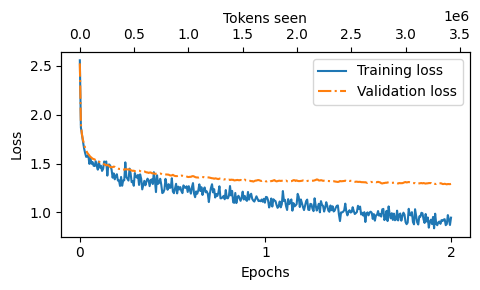

In [ ]:
from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['RESPONSE']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
This math problem has got me stumped: A group of security guards were hired for the night shift at a factory. The four guards agreed to a rotating schedule to cover the nine hours of the night shift. The first guard would take three hours since they were still awake, the last guard would wake up early and take two hours, and the middle two guards would split the remaining hours. How many hours will each middle guard take?
Can you show me the way?

Correct response:
>> The first and last guard will take 3 + 2 = 5 hours of the night shift.
There are 9 hours in the night shift, so the middle two guards will cover 9 - 5 = 4 hours.
Each middle guard will take 4 / 2 = 2 hours.

Model response:
>> The first guard would take 3 hours + 2 hours = 5 hours.
The second guard would take 5 hours + 2 hours = 7 hours.
The middle guard would take 7 hours - 2 hours = 5 hours.
Theref

In [ ]:
from tqdm import tqdm
import json
import torch
from llms_from_scratch.ch04 import GPTModel

with torch.inference_mode():
    for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
        input_text = format_input(entry)

        idx = text_to_token_ids(input_text, tokenizer).to(device)

        token_ids = generate(
            model=model,
            idx=idx,
            max_new_tokens=256,
            context_size=BASE_CONFIG["context_length"],
            eos_id=50256
        )

        generated_text = token_ids_to_text(token_ids, tokenizer)
        response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

        test_data[i]["finetuned_model_response"] = response_text
        entry["idx"] = i


100%|██████████| 879/879 [10:40<00:00,  1.37it/s]


In [ ]:
print(test_data[0])

{'INSTRUCTION': 'This math problem has got me stumped: A group of security guards were hired for the night shift at a factory. The four guards agreed to a rotating schedule to cover the nine hours of the night shift. The first guard would take three hours since they were still awake, the last guard would wake up early and take two hours, and the middle two guards would split the remaining hours. How many hours will each middle guard take?\nCan you show me the way?', 'RESPONSE': 'The first and last guard will take 3 + 2 = 5 hours of the night shift.\nThere are 9 hours in the night shift, so the middle two guards will cover 9 - 5 = 4 hours.\nEach middle guard will take 4 / 2 = 2 hours.', 'SOURCE': 'grade-school-math', 'finetuned_model_response': 'The first guard would take 3 hours + 2 hours = 5 hours.\nThe second guard would take 5 hours + 2 hours = 7 hours.\nThe middle guard would take 7 hours - 2 hours = 5 hours.\nTherefore, the middle guard will take 5 hours / 4 guards = 1 hour.', 'id

In [ ]:
with open("instruction-data-with-finetuned-response.json", "w") as f:
    json.dump(test_data, f, indent=4)

In [ ]:
import re

model_name = CHOOSE_MODEL + '-finetuned'
file_name = f"{re.sub(r'[ ()]', '', model_name) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-finetuned-sft.pth


In [ ]:
!sudo apt update
!sudo apt install -y pciutils zstd
!curl -fsSL https://ollama.com/install.sh | sh

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,361 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,745 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,300 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://ppa.launchpadcontent.net/deadsna

In [ ]:
# Starting Ollama proccess

import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

In [ ]:
!ollama pull llama3

In [ ]:
import json
import requests

def build_judge_prompt(entry):
    return f"""
You are a fair judge assistant tasked with providing clear, objective feedback based strictly on the rubric below.

You will be given:
- An instruction
- A candidate answer
- A reference answer (score 5 baseline)
- A scoring rubric

Evaluate ONLY according to the rubric.

Return ONLY valid JSON (no markdown, no explanations, no extra text) in the following format:

{{
  "evaluation": "<your rationale>",
  "total_rating": <number between 1 and 5>
}}

Rubric:
1: Fails to address the instruction, irrelevant or incorrect.
2: Partially addresses but with major inaccuracies or verbosity.
3: Mostly correct with minor issues or unnecessary detail.
4: Clear, accurate, concise with very minor issues.
5: Fully adheres, clear, accurate, concise, complete.

Instruction:
{format_input(entry)}

Reference Answer (score 5 baseline):
{entry['RESPONSE']}

Candidate Answer:
{entry['finetuned_model_response']}
""".strip()

def query_judge(
    entry,
    model="llama3",
    url="http://127.0.0.1:11434/api/chat"
):
    prompt = build_judge_prompt(entry)
    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        },
        "stream": True
    }

    with requests.post(url, json=data, stream=True, timeout=30) as r:
        r.raise_for_status()
        response_data = ""
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue
            response_json = json.loads(line)
            if "message" in response_json:
                response_data += response_json["message"]["content"]

    try:
        return json.loads(response_data)
    except json.JSONDecodeError:
        return {"error": "Judge did not return valid JSON", "raw": response_text}

In [ ]:
for entry in test_data[:3]:
    print("\nDataset response:")
    print(">>", entry['RESPONSE'])
    print("\nModel response:")
    print(">>", entry["finetuned_model_response"])
    print("\nScore:")
    print(">>", query_judge(entry))
    print("\n-------------------------")


Dataset response:
>> The first and last guard will take 3 + 2 = 5 hours of the night shift.
There are 9 hours in the night shift, so the middle two guards will cover 9 - 5 = 4 hours.
Each middle guard will take 4 / 2 = 2 hours.

Model response:
>> The first guard would take 3 hours + 2 hours = 5 hours.
The second guard would take 5 hours + 2 hours = 7 hours.
The middle guard would take 7 hours - 2 hours = 5 hours.
Therefore, the middle guard will take 5 hours / 4 guards = 1 hour.

Score:
>> {'evaluation': "Candidate answer partially addresses the instruction by correctly identifying the first and last guard's shifts, but incorrectly calculates the middle guards' shifts.", 'total_rating': 2}

-------------------------

Dataset response:
>> She caught 8 pounds of catfish because 4 x 2 = 8
She caught 4.5 pounds of catfish because 3 x 1.5 = 4.5
She caught 7.5 pounds of bluegill because 5 x 2.5 = 12.5
She caught 20 pounds of fish because 8 + 4.5 + 12.5 = 25

Model response:
>> The catfish 

In [ ]:
def generate_model_scores(json_data, json_key):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        judge_output = query_judge(entry)

        if not isinstance(judge_output, dict):
            print(f"Invalid judge output (not dict): {judge_output}")
            continue

        if "total_rating" not in judge_output:
            print(f"Missing total_rating: {judge_output}")
            continue

        try:
            rating = int(judge_output["total_rating"])
            scores.append(rating)
        except (ValueError, TypeError):
            print(f"Could not convert rating: {judge_output}")
            continue

    return scores


scores = generate_model_scores(test_data, "finetuned_model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   1%|          | 6/879 [00:01<04:03,  3.59it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   1%|          | 7/879 [00:01<04:05,  3.56it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   1%|          | 10/879 [00:02<04:02,  3.58it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   1%|▏         | 12/879 [00:03<04:03,  3.56it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   3%|▎         | 25/879 [00:06<04:17,  3.32it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   3%|▎         | 29/879 [00:08<04:10,  3.40it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   4%|▎         | 32/879 [00:08<04:06,  3.43it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   4%|▍         | 33/879 [00:09<04:23,  3.21it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   4%|▍         | 38/879 [00:10<03:56,  3.56it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   4%|▍         | 39/879 [00:11<03:53,  3.60it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   5%|▌         | 47/879 [00:13<04:31,  3.06it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   6%|▋         | 57/879 [00:16<03:41,  3.71it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   7%|▋         | 61/879 [00:17<03:45,  3.63it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   7%|▋         | 62/879 [00:17<04:38,  2.94it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   7%|▋         | 64/879 [00:18<03:56,  3.45it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   7%|▋         | 65/879 [00:18<04:05,  3.31it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   8%|▊         | 67/879 [00:18<03:52,  3.49it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   8%|▊         | 68/879 [00:19<04:04,  3.32it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:   9%|▉         | 82/879 [00:23<03:24,  3.90it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  10%|▉         | 86/879 [00:24<03:59,  3.31it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  11%|█         | 95/879 [00:26<04:21,  3.00it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  11%|█         | 96/879 [00:27<03:58,  3.28it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  11%|█▏        | 99/879 [00:27<03:28,  3.73it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  12%|█▏        | 103/879 [00:28<03:33,  3.64it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  12%|█▏        | 104/879 [00:29<04:01,  3.21it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  13%|█▎        | 113/879 [00:31<03:26,  3.70it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  13%|█▎        | 117/879 [00:33<03:28,  3.65it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  13%|█▎        | 118/879 [00:33<03:40,  3.45it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  14%|█▍        | 121/879 [00:34<03:34,  3.53it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  15%|█▌        | 135/879 [00:38<03:40,  3.37it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  15%|█▌        | 136/879 [00:38<03:41,  3.35it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  17%|█▋        | 147/879 [00:41<04:01,  3.02it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  18%|█▊        | 160/879 [00:45<03:35,  3.34it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  20%|█▉        | 172/879 [00:48<02:58,  3.97it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  20%|█▉        | 173/879 [00:48<03:25,  3.44it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  20%|██        | 176/879 [00:49<03:40,  3.19it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  21%|██        | 182/879 [00:51<03:19,  3.49it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  22%|██▏       | 190/879 [00:53<03:42,  3.10it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  22%|██▏       | 192/879 [00:54<03:22,  3.40it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  22%|██▏       | 194/879 [00:54<03:06,  3.67it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  23%|██▎       | 198/879 [00:55<03:03,  3.72it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  23%|██▎       | 204/879 [00:57<03:17,  3.42it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  24%|██▍       | 215/879 [01:00<03:20,  3.31it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  25%|██▍       | 219/879 [01:02<03:06,  3.54it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  25%|██▌       | 221/879 [01:02<03:15,  3.37it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  25%|██▌       | 222/879 [01:02<03:18,  3.31it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  26%|██▌       | 226/879 [01:04<03:37,  3.00it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  26%|██▌       | 228/879 [01:04<03:27,  3.14it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  26%|██▌       | 230/879 [01:05<03:11,  3.38it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  27%|██▋       | 237/879 [01:07<03:00,  3.56it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  28%|██▊       | 243/879 [01:09<03:21,  3.16it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  28%|██▊       | 247/879 [01:10<02:51,  3.70it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  28%|██▊       | 249/879 [01:10<03:24,  3.09it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  28%|██▊       | 250/879 [01:11<03:14,  3.23it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  31%|███       | 269/879 [01:16<02:41,  3.77it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  31%|███▏      | 276/879 [01:18<02:39,  3.78it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  32%|███▏      | 277/879 [01:18<03:09,  3.18it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  32%|███▏      | 282/879 [01:19<02:57,  3.37it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  33%|███▎      | 286/879 [01:21<02:49,  3.49it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  33%|███▎      | 287/879 [01:21<02:45,  3.58it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  33%|███▎      | 293/879 [01:22<02:49,  3.45it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  34%|███▎      | 295/879 [01:23<02:59,  3.26it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  35%|███▍      | 304/879 [01:26<03:17,  2.91it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  37%|███▋      | 321/879 [01:31<02:35,  3.59it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  37%|███▋      | 327/879 [01:32<02:54,  3.17it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  38%|███▊      | 331/879 [01:34<02:48,  3.25it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  38%|███▊      | 333/879 [01:34<02:44,  3.31it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  38%|███▊      | 338/879 [01:35<02:31,  3.57it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  39%|███▉      | 341/879 [01:36<02:35,  3.46it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  39%|███▉      | 346/879 [01:38<02:38,  3.36it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  40%|████      | 353/879 [01:40<02:30,  3.49it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  41%|████      | 356/879 [01:41<02:53,  3.01it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  41%|████      | 361/879 [01:42<02:41,  3.20it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  42%|████▏     | 369/879 [01:45<02:30,  3.39it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  42%|████▏     | 370/879 [01:45<02:36,  3.25it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  43%|████▎     | 374/879 [01:46<02:42,  3.11it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  43%|████▎     | 378/879 [01:47<02:26,  3.41it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  43%|████▎     | 381/879 [01:48<02:24,  3.44it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  44%|████▎     | 383/879 [01:49<02:22,  3.49it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  44%|████▍     | 385/879 [01:49<02:35,  3.17it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  44%|████▍     | 388/879 [01:50<02:25,  3.38it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  44%|████▍     | 391/879 [01:51<02:17,  3.56it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  45%|████▍     | 394/879 [01:52<02:06,  3.83it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  47%|████▋     | 410/879 [01:56<02:18,  3.39it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  47%|████▋     | 412/879 [01:57<02:07,  3.66it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  48%|████▊     | 419/879 [01:59<02:14,  3.42it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  48%|████▊     | 421/879 [01:59<02:21,  3.24it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  48%|████▊     | 424/879 [02:00<02:26,  3.10it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  49%|████▉     | 429/879 [02:02<02:27,  3.05it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  49%|████▉     | 433/879 [02:03<02:10,  3.41it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  50%|████▉     | 436/879 [02:04<01:54,  3.86it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  50%|████▉     | 439/879 [02:05<02:14,  3.28it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  50%|█████     | 443/879 [02:06<02:06,  3.44it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  51%|█████     | 444/879 [02:06<02:08,  3.39it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  51%|█████     | 450/879 [02:08<02:07,  3.36it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  52%|█████▏    | 458/879 [02:10<01:51,  3.78it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  52%|█████▏    | 459/879 [02:10<02:04,  3.36it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  53%|█████▎    | 467/879 [02:13<01:58,  3.49it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  53%|█████▎    | 468/879 [02:13<01:59,  3.43it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  53%|█████▎    | 470/879 [02:13<01:55,  3.53it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  54%|█████▍    | 475/879 [02:15<02:02,  3.30it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  54%|█████▍    | 476/879 [02:15<02:11,  3.05it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  54%|█████▍    | 478/879 [02:16<02:11,  3.06it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  56%|█████▌    | 488/879 [02:19<01:43,  3.79it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  56%|█████▌    | 492/879 [02:20<01:39,  3.89it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  57%|█████▋    | 501/879 [02:22<01:30,  4.18it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  57%|█████▋    | 502/879 [02:22<01:36,  3.90it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  58%|█████▊    | 506/879 [02:23<01:44,  3.58it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  58%|█████▊    | 514/879 [02:26<01:48,  3.37it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  59%|█████▉    | 520/879 [02:27<01:35,  3.76it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  59%|█████▉    | 521/879 [02:28<01:46,  3.35it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  60%|█████▉    | 524/879 [02:28<01:43,  3.43it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  61%|██████    | 536/879 [02:32<01:39,  3.46it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  62%|██████▏   | 547/879 [02:35<01:28,  3.75it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  63%|██████▎   | 550/879 [02:36<01:33,  3.51it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  63%|██████▎   | 551/879 [02:36<01:42,  3.21it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  63%|██████▎   | 557/879 [02:38<01:38,  3.26it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  65%|██████▍   | 569/879 [02:42<01:23,  3.70it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  65%|██████▍   | 570/879 [02:42<01:27,  3.53it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  65%|██████▌   | 572/879 [02:42<01:24,  3.64it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  65%|██████▌   | 574/879 [02:43<01:28,  3.44it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  66%|██████▌   | 580/879 [02:45<01:16,  3.92it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  67%|██████▋   | 588/879 [02:47<01:28,  3.28it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  67%|██████▋   | 589/879 [02:47<01:30,  3.19it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  67%|██████▋   | 590/879 [02:48<01:36,  3.00it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  68%|██████▊   | 600/879 [02:51<01:35,  2.92it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  69%|██████▉   | 607/879 [02:53<01:28,  3.08it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  70%|██████▉   | 612/879 [02:54<01:26,  3.10it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  70%|██████▉   | 614/879 [02:55<01:22,  3.22it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  70%|███████   | 617/879 [02:56<01:29,  2.93it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  71%|███████   | 621/879 [02:57<01:23,  3.09it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  71%|███████   | 626/879 [02:58<01:18,  3.22it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  71%|███████▏  | 628/879 [02:59<01:12,  3.44it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  72%|███████▏  | 630/879 [02:59<01:04,  3.88it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  73%|███████▎  | 642/879 [03:03<01:05,  3.61it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  73%|███████▎  | 646/879 [03:04<01:12,  3.23it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  74%|███████▍  | 649/879 [03:05<01:06,  3.44it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  74%|███████▍  | 653/879 [03:06<01:08,  3.28it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  75%|███████▍  | 656/879 [03:07<01:06,  3.34it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  75%|███████▍  | 657/879 [03:07<01:03,  3.50it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  76%|███████▌  | 668/879 [03:10<00:58,  3.59it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  76%|███████▋  | 671/879 [03:11<00:58,  3.53it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  77%|███████▋  | 676/879 [03:13<01:04,  3.15it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  77%|███████▋  | 678/879 [03:13<00:57,  3.50it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  78%|███████▊  | 683/879 [03:14<00:59,  3.30it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  78%|███████▊  | 684/879 [03:15<01:05,  2.97it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  78%|███████▊  | 685/879 [03:15<01:06,  2.92it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  79%|███████▉  | 698/879 [03:19<00:52,  3.42it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  80%|███████▉  | 702/879 [03:20<00:48,  3.66it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  81%|████████  | 712/879 [03:22<00:45,  3.66it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  82%|████████▏ | 718/879 [03:24<00:50,  3.18it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  82%|████████▏ | 719/879 [03:24<00:50,  3.18it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  82%|████████▏ | 724/879 [03:26<00:44,  3.45it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  83%|████████▎ | 731/879 [03:28<00:43,  3.41it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  84%|████████▍ | 739/879 [03:30<00:35,  3.98it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  84%|████████▍ | 740/879 [03:30<00:39,  3.55it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  84%|████████▍ | 742/879 [03:31<00:38,  3.53it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  85%|████████▍ | 747/879 [03:32<00:44,  3.00it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  86%|████████▌ | 752/879 [03:34<00:38,  3.33it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  86%|████████▌ | 758/879 [03:35<00:31,  3.84it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  86%|████████▋ | 759/879 [03:36<00:32,  3.67it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  87%|████████▋ | 761/879 [03:36<00:34,  3.42it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  88%|████████▊ | 775/879 [03:40<00:32,  3.24it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  89%|████████▉ | 784/879 [03:43<00:30,  3.11it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  90%|█████████ | 793/879 [03:45<00:25,  3.36it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  92%|█████████▏| 810/879 [03:50<00:19,  3.58it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  93%|█████████▎| 816/879 [03:52<00:18,  3.42it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  93%|█████████▎| 819/879 [03:53<00:17,  3.39it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  94%|█████████▎| 824/879 [03:54<00:15,  3.59it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  94%|█████████▍| 827/879 [03:55<00:15,  3.45it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  95%|█████████▍| 834/879 [03:57<00:14,  3.16it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  95%|█████████▌| 838/879 [03:59<00:12,  3.23it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  95%|█████████▌| 839/879 [03:59<00:13,  3.05it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  96%|█████████▌| 841/879 [04:00<00:13,  2.83it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  96%|█████████▋| 847/879 [04:01<00:09,  3.33it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  96%|█████████▋| 848/879 [04:02<00:09,  3.14it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  97%|█████████▋| 851/879 [04:03<00:08,  3.31it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  97%|█████████▋| 852/879 [04:03<00:07,  3.40it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  97%|█████████▋| 855/879 [04:04<00:07,  3.24it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  99%|█████████▉| 872/879 [04:08<00:01,  3.58it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries:  99%|█████████▉| 874/879 [04:09<00:01,  3.64it/s]

Missing total_rating: {'error': 'Judge did not return valid JSON', 'raw': 'Antoine needs 2 * 6 = 12 pounds of onions.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 4 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 2 * 2 = 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe needs 8 pounds of beef stock.\nHe'}


Scoring entries: 100%|██████████| 879/879 [04:10<00:00,  3.50it/s]

Number of scores: 698 of 879
Average score: 2.17



### LLM-As-a-Judge - GPT2 vs GPT2 Finetuned

In [ ]:
drop_finetuned_columns = ["SOURCE", "idx"]

finetuned_df = pd.read_json('/content/instruction-data-with-finetuned-response.json')
finetuned_df.drop(columns=drop_finetuned_columns, inplace=True)

finetuned_df.head()

,INSTRUCTION,RESPONSE,finetuned_model_response
0,This math problem has got me stumped: A group ...,The first and last guard will take 3 + 2 = 5 h...,The first guard would take 3 hours + 2 hours =...
1,Emily goes fishing and has a very busy day. Sh...,She caught 8 pounds of catfish because 4 x 2 =...,"The catfish weigh 1.5 pounds each, so the catf..."
2,I would love to understand how to solve this p...,Ahmed has scored 819 total points in the class...,Ahmed needs to get a total of 9 + 91 = 92.\nEm...
3,I'm completely lost with this math problem: De...,Melissa has 16 / 2 = 8 dresses.\nDebora has 8 ...,Melissa has 16/2=8 dresses.\nThe total number ...
4,I'm completely lost with this math problem: Fr...,First find the total number of The Art of the ...,First find the total number of votes for Game ...


In [ ]:
drop_untrained_columns = ["SOURCE", "RESPONSE", "idx"]

untrained_df = pd.read_json('/content/instruction-data-with-untrained-response.json')

untrained_df.drop(columns=drop_untrained_columns, inplace=True)
untrained_df.head()

,INSTRUCTION,untrained_model_response
0,This math problem has got me stumped: A group ...,### Answer:\n\nThe answer is:\n\n### Instructi...
1,Emily goes fishing and has a very busy day. Sh...,.\n\n### Solution:\n\nEmily has a very busy da...
2,I would love to understand how to solve this p...,### Answer:\n\nAhmed and Emily are having a co...
3,I'm completely lost with this math problem: De...,### Answer:\n\nEmily has 16 dresses.\n\n### In...
4,I'm completely lost with this math problem: Fr...,### Result:\nThe answer is: 80% of the votes w...


In [ ]:
# Preprocessing df with responses

merged_df = pd.merge(finetuned_df, untrained_df, on='INSTRUCTION')
merged_df = merged_df.rename(columns={"RESPONSE": "expected_response", "INSTRUCTION": "instruction"})

merged_df.head()

,instruction,expected_response,finetuned_model_response,untrained_model_response
0,This math problem has got me stumped: A group ...,The first and last guard will take 3 + 2 = 5 h...,The first guard would take 3 hours + 2 hours =...,### Answer:\n\nThe answer is:\n\n### Instructi...
1,Emily goes fishing and has a very busy day. Sh...,She caught 8 pounds of catfish because 4 x 2 =...,"The catfish weigh 1.5 pounds each, so the catf...",.\n\n### Solution:\n\nEmily has a very busy da...
2,I would love to understand how to solve this p...,Ahmed has scored 819 total points in the class...,Ahmed needs to get a total of 9 + 91 = 92.\nEm...,### Answer:\n\nAhmed and Emily are having a co...
3,I'm completely lost with this math problem: De...,Melissa has 16 / 2 = 8 dresses.\nDebora has 8 ...,Melissa has 16/2=8 dresses.\nThe total number ...,### Answer:\n\nEmily has 16 dresses.\n\n### In...
4,I'm completely lost with this math problem: Fr...,First find the total number of The Art of the ...,First find the total number of votes for Game ...,### Result:\nThe answer is: 80% of the votes w...


In [ ]:
# Calling llm-as-a-judge for a row
import requests

def build_pairwise_judge_prompt_from_row(row):
    return f"""
      You are a fair judge assistant.

      Evaluate two answers (A and B) to the same instruction.

      Return ONLY valid JSON in this exact format:
      {{
        "scores": {{
          "A": {{
            "factual_correctness": <0-5>,
            "instruction_adherence": <0-5>,
            "clarity_utility": <0-5>
          }},
          "B": {{
            "factual_correctness": <0-5>,
            "instruction_adherence": <0-5>,
            "clarity_utility": <0-5>
          }}
        }},
        "winner": "A" | "B" | "tie",
        "justification": "<short explanation>"
      }}

      Instruction:
      {row["instruction"]}

      Reference Answer (ground truth):
      {row["expected_response"]}

      Answer A (Untrained model):
      {row["untrained_model_response"]}

      Answer B (Finetuned model):
      {row["finetuned_model_response"]}
    """.strip()


def query_judge_pairwise_row(
    row,
    model="llama3",
    url="http://127.0.0.1:11434/api/chat"
):
    prompt = build_pairwise_judge_prompt_from_row(row)

    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        },
        "stream": True
    }

    response_text = ""
    with requests.post(url, json=data, stream=True, timeout=60) as r:
        r.raise_for_status()
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue
            chunk = json.loads(line)
            if "message" in chunk:
                response_text += chunk["message"]["content"]

    try:
        return json.loads(response_text)
    except json.JSONDecodeError:
        return {"error": "Invalid JSON", "raw": response_text}


In [ ]:
# Comparing both models function:

from tqdm import tqdm

def evaluate_dataframe(df):
    results = []
    winner_counts = {"A": 0, "B": 0, "tie": 0}
    bad = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Judging"):
        judge_output = query_judge_pairwise_row(row)

        if "error" in judge_output:
            bad += 1
            continue

        try:
            scores_A = judge_output["scores"]["A"]
            scores_B = judge_output["scores"]["B"]

            avg_A = (
                scores_A["factual_correctness"] +
                scores_A["instruction_adherence"] +
                scores_A["clarity_utility"]
            ) / 3

            avg_B = (
                scores_B["factual_correctness"] +
                scores_B["instruction_adherence"] +
                scores_B["clarity_utility"]
            ) / 3

            avg_A = round(avg_A, 2)
            avg_B = round(avg_B, 2)
            if avg_A > avg_B:
               winner = "A"
            elif avg_A == avg_B:
               winner = "tie"
            else: winner = 'B'

            winner_counts[winner] += 1

            results.append({
                "avg_A": avg_A,
                "avg_B": avg_B,
                "winner": winner
            })

        except Exception as e:
            print("Parsing error:", judge_output)
            bad += 1

    return results, winner_counts, bad

In [ ]:
results, winner_counts, bad = evaluate_dataframe(merged_df)

avg_A = sum(r["avg_A"] for r in results) / len(results)
avg_B = sum(r["avg_B"] for r in results) / len(results)

print(f"\nEvaluated: {len(results)} of {len(merged_df)} (bad: {bad})")
print(f"Average A (Untrained): {avg_A:.2f}")
print(f"Average B (Finetuned): {avg_B:.2f}")
print(f"Winner counts: {winner_counts}")


Judging: 100%|██████████| 879/879 [09:43<00:00,  1.51it/s]


Evaluated: 626 of 879 (bad: 253)
Average A (Untrained): 0.90
Average B (Finetuned): 4.48
Winner counts: {'A': 12, 'B': 613, 'tie': 1}


In [ ]:
# Printing a random sample from the df

import random
import textwrap

def print_comparison(row, idx, width=60):
    print("\n" + "=" * (width * 2 + 5))
    print(f"INDEX {idx}")
    print("=" * (width * 2 + 5))

    print("\nINSTRUCTION:\n")
    print(textwrap.fill(str(row["instruction"]), width=width*2))

    print("\n" + "-" * (width * 2 + 5))

    untrained = textwrap.wrap(str(row["untrained_model_response"]), width=width)
    finetuned = textwrap.wrap(str(row["finetuned_model_response"]), width=width)

    max_lines = max(len(untrained), len(finetuned))

    print(f"\n{'UNTRAINED MODEL'.ljust(width)} | {'FINETUNED MODEL'.ljust(width)}")
    print("-" * (width * 2 + 3))

    for i in range(max_lines):
        left = untrained[i] if i < len(untrained) else ""
        right = finetuned[i] if i < len(finetuned) else ""
        print(f"{left.ljust(width)} | {right.ljust(width)}")

    print("\n")


random_indices = random.sample(range(len(merged_df)), 2)

for idx in random_indices:
    row = merged_df.iloc[idx]
    print_comparison(row, idx)



INDEX 281

INSTRUCTION:

Break down this math problem: A chef needs to make french fries.  He can get 25 fries out of 1 potato.  He has 15
potatoes and he needs 200 fries.  How many potatoes will he have leftover?

-----------------------------------------------------------------------------------------------------------------------------

UNTRAINED MODEL                                              | FINETUNED MODEL                                             
---------------------------------------------------------------------------------------------------------------------------
How many fries will he need to make a full meal?  How many   | He needs 200 fries and he has 15 potatoes so he needs 200/15
fries will he need to make a half meal?  How many fries will | = 10 potatoes He has 10 potatoes and he needs 10 potatoes so
he need to make a quarter meal?  How many fries will he need | he will have 10-10 = 5 potatoes leftover                    
to make a quarter meal?  How many fri

In [ ]:
# Results of above judge judgements

for idx in random_indices:
    row = merged_df.iloc[idx]
    print(query_judge_pairwise_row(row))

{'scores': {'A': {'factual_correctness': 0, 'instruction_adherence': 1, 'clarity_utility': 2}, 'B': {'factual_correctness': 4, 'instruction_adherence': 5, 'clarity_utility': 5}}, 'winner': 'B', 'justification': 'Answer B correctly solved the problem, while Answer A did not address the original question and provided irrelevant information.'}
{'scores': {'A': {'factual_correctness': 0, 'instruction_adherence': 1, 'clarity_utility': 1}, 'B': {'factual_correctness': 4, 'instruction_adherence': 5, 'clarity_utility': 5}}, 'winner': 'B', 'justification': 'Answer B shows a clear understanding of the problem and correctly applies the given information to solve it. Answer A, on the other hand, is irrelevant to the problem and does not demonstrate any attempt to solve it.'}


# Training a model to classify the news type in the ag_news dataset

In [ ]:
# Loading ag_news dataset
import pandas as pd

splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
df = pd.read_json("hf://datasets/sh0416/ag_news/" + splits["train"], lines=True)

df.head()

,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
# Mapping the dataset label to its corresponding name:

#1: World 2: Sports 3: Business 4: Sci/Tech
LABELS = ["World", "Sports", "Business", "Sci/Tech"]

df["label"] = df["label"].apply(lambda x: LABELS[x - 1])
df.head()

,label,title,description
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
def format_input(entry, with_response=True):
    instruction_text = (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n"
        "Classify the following news into one of these labels: World | Sports | Business | Sci/Tech\n\n"
        "### Input:\n"
    )

    input_content = entry.get('title')
    if not input_content:
        input_content = entry.get('description', '')
    input_content = str(input_content).strip()

    prompt_text = instruction_text + input_content + "\n\n### Response:\n"

    if with_response:
        answer = entry["label"].strip()
        full_text = prompt_text + answer
        return full_text
    else:
        return prompt_text

In [ ]:
full_text = format_input(df.iloc[50], with_response=True)

print(full_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify the following news into one of these labels: World | Sports | Business | Sci/Tech

### Input:
If Hurricane Charley blows your house down, how can you make your insurance company pay?

### Response:
Business


In [ ]:
# Splitting the dataset
train_portion = int(len(df) * 0.8)
test_portion = int(len(df) * 0.1)
val_portion = len(df) - train_portion - test_portion

train_data = df[:train_portion]
test_data = df[train_portion:train_portion + test_portion]
val_data = df[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 96000
Validation set length: 12000
Test set length: 12000


In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.encoded_texts = []
        for entry in data:
            # For training, we need the full text including the response
            full_text_with_response = format_input(entry, with_response=True)
            self.encoded_texts.append(
                tokenizer.encode(full_text_with_response)
            )

In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data.to_dict('records'), tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data.to_dict('records'), tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data.to_dict('records'), tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

NameError: name 'custom_collate_fn' is not defined

In [ ]:
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 407kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.27MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 413kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [05:43<00:00, 4.14MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 50.7MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 3.60MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.16MiB/s]


In [ ]:
from llms_from_scratch.ch05 import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

# For generation, we want the input_text without the expected response
input_text = format_input(val_data.iloc[0], with_response=False)
print(input_text)

token_ids = generate(
    model=model.to(device),
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

torch.manual_seed(123)

# For printing the original formatted input (with response for comparison)
# We'll print it here as original_formatted_input to avoid confusion
original_formatted_input = format_input(val_data.iloc[0], with_response=True)
print(original_formatted_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify the following news into one of these labels: World | Sports | Business | Sci/Tech

### Input:
The IMF has said it will negotiate with Argentina after  the country's debt swap, that was delayed until 17 January.

### Response:
Business


In [ ]:
response_text = (
    generated_text[len(input_text):] # input_text here is the prompt without the ground truth
    .replace("### Response:", "")
    .strip()
)
print(response_text)

es and governments are expected to pay the IMF $1.5 billion in interest over the next two years.

### Output:

The IMF has said it will


In [ ]:
import time
from llms_from_scratch.ch05 import (
    calc_loss_loader,
    train_model_simple
)

model.to(device)

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    # For calculating loss, we need the full text including the response
    start_context=format_input(val_data.iloc[0], with_response=True), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.171, Val loss 3.131
Ep 1 (Step 000005): Train loss 1.678, Val loss 1.543
Ep 1 (Step 000010): Train loss 1.458, Val loss 1.436
Ep 1 (Step 000015): Train loss 1.529, Val loss 1.404
Ep 1 (Step 000020): Train loss 1.416, Val loss 1.385
Ep 1 (Step 000025): Train loss 1.408, Val loss 1.379
Ep 1 (Step 000030): Train loss 1.391, Val loss 1.370
Ep 1 (Step 000035): Train loss 1.257, Val loss 1.362
Ep 1 (Step 000040): Train loss 1.349, Val loss 1.356
Ep 1 (Step 000045): Train loss 1.401, Val loss 1.351
Ep 1 (Step 000050): Train loss 1.368, Val loss 1.343
Ep 1 (Step 000055): Train loss 1.370, Val loss 1.336
Ep 1 (Step 000060): Train loss 1.499, Val loss 1.339
Ep 1 (Step 000065): Train loss 1.224, Val loss 1.329
Ep 1 (Step 000070): Train loss 1.270, Val loss 1.326
Ep 1 (Step 000075): Train loss 1.306, Val loss 1.325
Ep 1 (Step 000080): Train loss 1.240, Val loss 1.319
Ep 1 (Step 000085): Train loss 1.261, Val loss 1.315
Ep 1 (Step 000090): Train loss 1.324, Val loss

Training loss: 0.6765916466712951
Validation loss: 1.2593749284744262


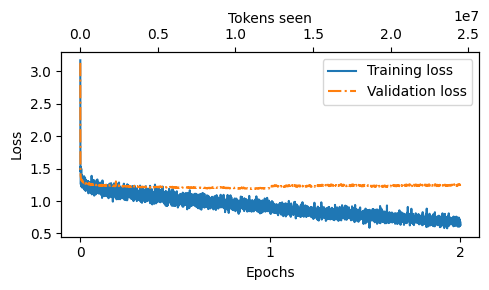

In [ ]:
from llms_from_scratch.ch05 import plot_losses

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Resultados do modelo finetunado na classificacao do ag_news

In [ ]:
torch.manual_seed(123)

for entry in test_data[:3].to_dict('records'):
    input_text = format_input(entry, with_response=False)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):]

    response_text = response_text.replace("### Response:", "").strip()

    print(f"\nCorrect response:\n>> {entry['label']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")


Correct response:
>> Sci/Tech

Model response:
>> Sci/Tech
-------------------------------------

Correct response:
>> Sports

Model response:
>> Sports
-------------------------------------

Correct response:
>> Sci/Tech

Model response:
>> Sci/Tech
-------------------------------------


In [ ]:
from tqdm import tqdm
import json
import torch
from llms_from_scratch.ch04 import GPTModel

test_data_processed = test_data.to_dict('records')

with torch.inference_mode():
    for i, entry in tqdm(enumerate(test_data_processed), total=len(test_data_processed)):
        input_text = format_input(entry, with_response=False)

        idx = text_to_token_ids(input_text, tokenizer).to(device)

        token_ids = generate(
            model=model,
            idx=idx,
            max_new_tokens=256,
            context_size=BASE_CONFIG["context_length"],
            eos_id=50256
        )

        generated_text = token_ids_to_text(token_ids, tokenizer)
        response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

        entry["finetuned_model_response"] = response_text
        entry["idx"] = i

100%|██████████| 12000/12000 [04:32<00:00, 44.12it/s]


In [ ]:
with open("instruction-data-with-finetuned-response.json", "w") as f:
    json.dump(test_data_processed, f, indent=4)

In [ ]:
correct_predictions = 0
incorrect_predictions = 0

for entry in test_data_processed:
    if entry['finetuned_model_response'].strip().lower() == entry['label'].strip().lower():
        correct_predictions += 1
    else:
        incorrect_predictions += 1

total_entries = len(test_data_processed)
accuracy = (correct_predictions / total_entries) * 100 if total_entries > 0 else 0

print(f"Total entries: {total_entries}")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")
print(f"Accuracy: {accuracy:.2f}%")

Total entries: 12000
Correct predictions: 9116
Incorrect predictions: 2884
Accuracy: 75.97%


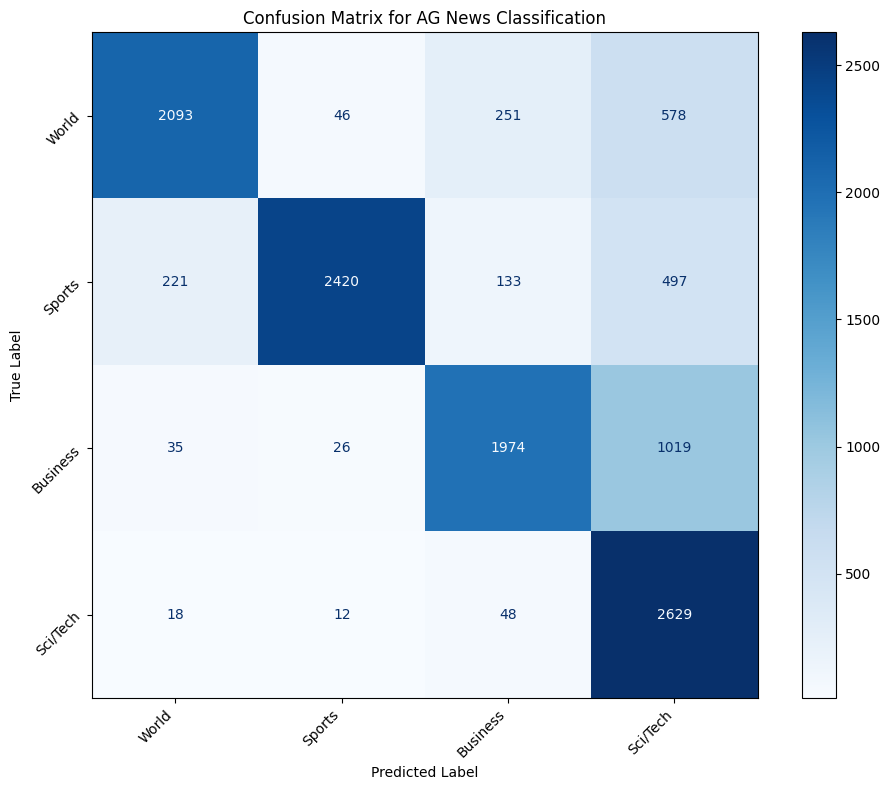

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

true_labels = [entry['label'] for entry in test_data_processed]
predicted_labels = [entry['finetuned_model_response'] for entry in test_data_processed]

class_labels = LABELS

cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)

ax.set_title('Confusion Matrix for AG News Classification')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
for entry in test_data_processed:
    if entry['label'].strip().lower() == 'business' and entry['finetuned_model_response'].strip().lower() == 'sci/tech':
        print(f"Título: {entry['title']}")
        print(f"Descrição: {entry['description']}")
        break

Título: EMI sales slip on weak release schedule
Descrição: EMI has blamed a weak release schedule for a failure to exploit an improvement in the music sector, with sales falling by more than four times the industry average.


In [ ]:
import torch

from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt

untrained_model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(untrained_model, params)
untrained_model.eval()
untrained_model.to(device)
print("Untrained GPT2 model loaded successfully.")

Untrained GPT2 model loaded successfully.


In [ ]:
import torch
import pandas as pd
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt, generate, text_to_token_ids, token_ids_to_text
import json
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

ag_news_test_with_untrained_response = test_data.to_dict('records')

def extract_label_from_untrained_response(response_text, labels):
    response_text_lower = response_text.lower()
    for label in labels:
        if label.lower() in response_text_lower:
            return label
    return "unknown"

untrained_predictions = []
true_ag_news_labels = []

with torch.inference_mode():
    for i, entry in tqdm(enumerate(ag_news_test_with_untrained_response), total=len(ag_news_test_with_untrained_response), desc="Generating untrained responses"):
        input_text = format_input(entry, with_response=False)

        idx = text_to_token_ids(input_text, tokenizer).to(device)

        token_ids = generate(
            model=untrained_model,
            idx=idx,
            max_new_tokens=35,
            context_size=BASE_CONFIG["context_length"],
            eos_id=50256,
        )

        generated_text = token_ids_to_text(token_ids, tokenizer)
        response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

        ag_news_test_with_untrained_response[i]["untrained_model_response"] = response_text

        predicted_label = extract_label_from_untrained_response(response_text, LABELS)
        untrained_predictions.append(predicted_label)
        true_ag_news_labels.append(entry['label'])

with open("instruction-data-with-untrained-response.json", "w") as f:
    json.dump(ag_news_test_with_untrained_response, f, indent=4)

cm_untrained = confusion_matrix(true_ag_news_labels, untrained_predictions, labels=LABELS)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_untrained, display_labels=LABELS)
disp.plot(cmap=plt.cm.Blues, ax=ax)

ax.set_title('Confusion Matrix for Untrained Model on AG News Classification')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

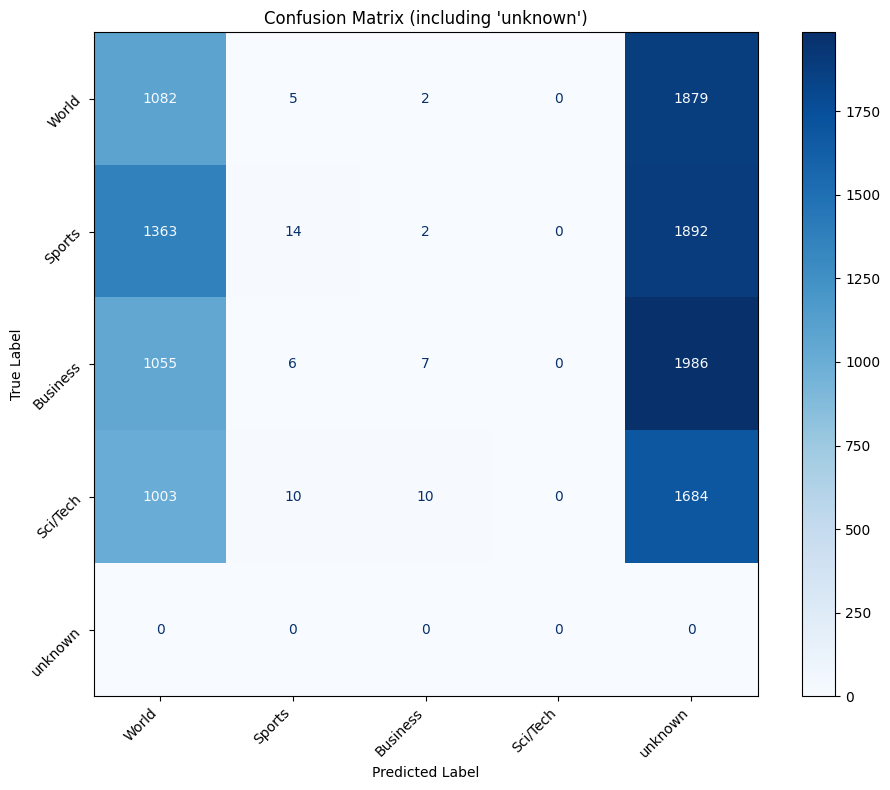

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

BASE_LABELS = ["World", "Sports", "Business", "Sci/Tech"]
ALL_LABELS = BASE_LABELS + ["unknown"]

def extract_label_from_response(response_text, labels):
    if response_text is None:
        return "unknown"
    response_text_lower = str(response_text).lower()
    for label in labels:
        if label.lower() in response_text_lower:
            return label
    return "unknown"

json_path = "instruction-data-with-untrained-response.json"
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

y_true = []
y_pred = []

for entry in data:
    true_label = entry.get("label", "unknown")
    if true_label not in BASE_LABELS:
        true_label = "unknown"

    resp = entry.get("untrained_model_response", "")
    pred_label = extract_label_from_response(resp, BASE_LABELS)

    y_true.append(true_label)
    y_pred.append(pred_label)

cm = confusion_matrix(y_true, y_pred, labels=ALL_LABELS)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ALL_LABELS)
disp.plot(cmap=plt.cm.Blues, ax=ax)

ax.set_title("Confusion Matrix (including 'unknown')")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

untrained_df = pd.read_json("instruction-data-with-untrained-response-ag-news.json")
untrained_df.head()

,label,title,description,untrained_model_response
0,Sci/Tech,Running Extra Mile Sets Humans Apart in Primat...,The ability of early human ancestors to run lo...,### Output:\n\n### Classification:\n\n### Worl...
1,Sports,"Harris, Miami Upend No. 19 Florida 72-65 (AP)",AP - Anthony Harris scored 18 of his career-hi...,"Harris, Miami Upend No. 19 Florida 72-65 (AP)\..."
2,Sci/Tech,Evidence Hints at Earlier Humans in Americas,Archaeologists in South Carolina announced rad...,### Output:\n\n### Instruction:\n\nClassify th...
3,Sci/Tech,"Joseph Weiss, 80, Originator of Theory on Faci...",Dr. Joseph Weiss was a psychoanalyst and resea...,### Output:\n\n### Comments:\n\n### Comments:\...
4,World,Aishwarya Rai to star in Hollywood blockbuster...,AFP - Bollywood's Aishwarya Rai is set to star...,Aishwarya Rai to star in Hollywood blockbuster...


In [ ]:
finetuned_df = pd.read_json("instruction-data-with-finetuned-response-ag-news.json")
finetuned_df.head()

,label,title,description,finetuned_model_response,idx
0,Sci/Tech,Running Extra Mile Sets Humans Apart in Primat...,The ability of early human ancestors to run lo...,Sci/Tech,0
1,Sports,"Harris, Miami Upend No. 19 Florida 72-65 (AP)",AP - Anthony Harris scored 18 of his career-hi...,Sports,1
2,Sci/Tech,Evidence Hints at Earlier Humans in Americas,Archaeologists in South Carolina announced rad...,Sci/Tech,2
3,Sci/Tech,"Joseph Weiss, 80, Originator of Theory on Faci...",Dr. Joseph Weiss was a psychoanalyst and resea...,Sci/Tech,3
4,World,Aishwarya Rai to star in Hollywood blockbuster...,AFP - Bollywood's Aishwarya Rai is set to star...,World,4


In [ ]:
finetuned_df = finetuned_df.drop(columns=['idx'])
finetuned_df.head()

,label,title,description,finetuned_model_response
0,Sci/Tech,Running Extra Mile Sets Humans Apart in Primat...,The ability of early human ancestors to run lo...,Sci/Tech
1,Sports,"Harris, Miami Upend No. 19 Florida 72-65 (AP)",AP - Anthony Harris scored 18 of his career-hi...,Sports
2,Sci/Tech,Evidence Hints at Earlier Humans in Americas,Archaeologists in South Carolina announced rad...,Sci/Tech
3,Sci/Tech,"Joseph Weiss, 80, Originator of Theory on Faci...",Dr. Joseph Weiss was a psychoanalyst and resea...,Sci/Tech
4,World,Aishwarya Rai to star in Hollywood blockbuster...,AFP - Bollywood's Aishwarya Rai is set to star...,World


In [ ]:
merged = finetuned_df.merge(
    untrained_df[["title", "untrained_model_response"]],
    on="title",
    how="inner"
)

merged.head()

,label,title,description,finetuned_model_response,untrained_model_response
0,Sci/Tech,Running Extra Mile Sets Humans Apart in Primat...,The ability of early human ancestors to run lo...,Sci/Tech,### Output:\n\n### Classification:\n\n### Worl...
1,Sports,"Harris, Miami Upend No. 19 Florida 72-65 (AP)",AP - Anthony Harris scored 18 of his career-hi...,Sports,"Harris, Miami Upend No. 19 Florida 72-65 (AP)\..."
2,Sci/Tech,Evidence Hints at Earlier Humans in Americas,Archaeologists in South Carolina announced rad...,Sci/Tech,### Output:\n\n### Instruction:\n\nClassify th...
3,Sci/Tech,"Joseph Weiss, 80, Originator of Theory on Faci...",Dr. Joseph Weiss was a psychoanalyst and resea...,Sci/Tech,### Output:\n\n### Comments:\n\n### Comments:\...
4,World,Aishwarya Rai to star in Hollywood blockbuster...,AFP - Bollywood's Aishwarya Rai is set to star...,World,Aishwarya Rai to star in Hollywood blockbuster...


In [ ]:
merged.to_csv("instruction-data-with-finetuned-and-untrained-response-ag-news.csv", index=False)